In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
from sklearn.linear_model import LogisticRegression, Lasso
import seaborn as sns
import numpy as np
import utils
from Model import Model
import matplotlib.pyplot as plt
from tqdm import tqdm
from PrecisionMatrixBuilder import PrecisionMatrixBuilder
from Forecaster import Forecaster
from MyDataLoader import MyDataLoader
from PortfolioConstructor import PortfolioConstructor
from BackTester import BackTester
#from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, GroupNormalizer, Baseline
#from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, RMSE
#from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import torch
#import pytorch_lightning as pl

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

Stellantis and WLN have a lot of missing prices compared to the other stocks in the CAC40: we exclude them from this analysis.

In [2]:
dataloader = MyDataLoader()
full_dataset, stock_names, time_index = dataloader.load_full_dataset_array()

[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
column_names = dataloader.load_feature_names()

In [3]:
tscv = list(utils.time_series_cross_validation(full_dataset, time_index, n_splits=10, valid_size=66, test_size=66))

In [5]:
config = utils.load_config()
alphas = config["alphas"]
thetas = config["thetas"]
lambdas = config["lambdas"]
capital = config["capital"]

In [6]:
returns = dataloader.load_returns()

The following cells can be run once to download the precision matrix if it is not already saved. 

In [8]:
import pickle
precision_matrix_builder = PrecisionMatrixBuilder(returns = returns, window = 512, alphas = alphas, thetas = thetas)
prec_mat = precision_matrix_builder.get_precision_matrix()

100%|██████████| 2930/2930 [12:20<00:00,  3.96it/s]   


In [9]:
with open('precision_mat.pkl', 'wb') as f:  # open a text file
    pickle.dump(prec_mat, f)

In [10]:
with open("precision_mat.pkl", "rb") as f:
    prec_mat = pickle.load(f)

In [11]:
benchmark_returns = dataloader.load_benchmark(date_index=time_index)
risk_free = dataloader.load_risk_free_rate(time_index)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
from Forecaster import Forecaster
forecaster = Forecaster(full_dataset, stock_names, time_index, valid_size=66, test_size=66, n_splits=10)

# Model Initialization

We now import and define the models of interest for each class: 

### MLP

In [279]:
from networks import MLP

hiddens1 = (torch.ones(10)*32).to(int)
hiddens2 = (torch.ones(10)*64).to(int)
hiddens3 = (torch.ones(50)*64).to(int)
model_1 = Model(name = "MultiLayerPerceptronRegression1", type = "regression", model_class= MLP(14, hiddens1, model_type="regression"))
model_2 = Model(name = "MultiLayerPerceptronRegression2", type = "regression", model_class= MLP(14, hiddens2, model_type="regression"))
model_3 = Model(name = "MultiLayerPerceptronRegression3", type = "regression", model_class= MLP(14, hiddens3, model_type="regression"))
model_4 = Model(name = "MultiLayerPerceptronClassification1", type = "classification", model_class= MLP(14, hiddens1, model_type="classification"))
model_5 = Model(name = "MultiLayerPerceptronClassification2", type = "classification", model_class= MLP(14, hiddens2, model_type="classification"))
model_6 = Model(name = "MultiLayerPerceptronClassification3", type = "classification", model_class= MLP(14, hiddens3, model_type="classification"))

MLP_models = [model_1, model_2, model_3, model_4, model_5, model_6]

tensor(32)
tensor(64)
tensor(64)
tensor(32)
tensor(64)
tensor(64)


We then perform training and forecasting on the defined models.

In [281]:
forecasts_val, forecasts_test, weights_valid, weights_test, opt_param_dict, valid_index_full, test_index_full = forecaster.evaluate_test_models(models = MLP_models, prec_mat = prec_mat, lambdas = lambdas, alphas = alphas, thetas = thetas, capital = capital, stock_returns=returns, risk_free=risk_free, benchmark_returns=benchmark_returns)

100%|██████████| 6/6 [11:29<00:00, 114.95s/it]
10it [3:53:16, 1399.64s/it]


MultiLayerPerceptronRegression1
(10, 66, 38)
MultiLayerPerceptronRegression2
(10, 66, 38)
MultiLayerPerceptronRegression3
(10, 66, 38)
MultiLayerPerceptronClassification1
(10, 66, 38)
MultiLayerPerceptronClassification2
(10, 66, 38)
MultiLayerPerceptronClassification3
(10, 66, 38)


In [101]:
weights_test_full_MLP_regressions = []
weights_test_full_MLP_classifications = []
for model in MLP_models: 
    if model.type == "regression": 
        weights_test_full_MLP_regressions.append(weights_test[model.name])
    else: 
        weights_test_full_MLP_classifications.append(weights_test[model.name])

Now, we perform backtesting and plot the results of the optimized portfolios.

Yearly excess returns        0.516115
Yearly standard deviation    1.619382
Max DD                       2.524873
Yearly Sharpe                0.318711
Yearly Calmar                0.204412
Yearly Sortino               0.521281
Daily Turnover               2.521689
dtype: float64
Yearly excess returns        -0.602915
Yearly standard deviation     1.733038
Max DD                       10.088440
Yearly Sharpe                -0.347895
Yearly Calmar                -0.059763
Yearly Sortino               -0.438230
Daily Turnover                1.989806
dtype: float64
Yearly excess returns        -0.017942
Yearly standard deviation     0.030659
Max DD                       13.464791
Yearly Sharpe                -0.585217
Yearly Calmar                -0.001333
Yearly Sortino               -0.825356
Daily Turnover                0.003378
dtype: float64


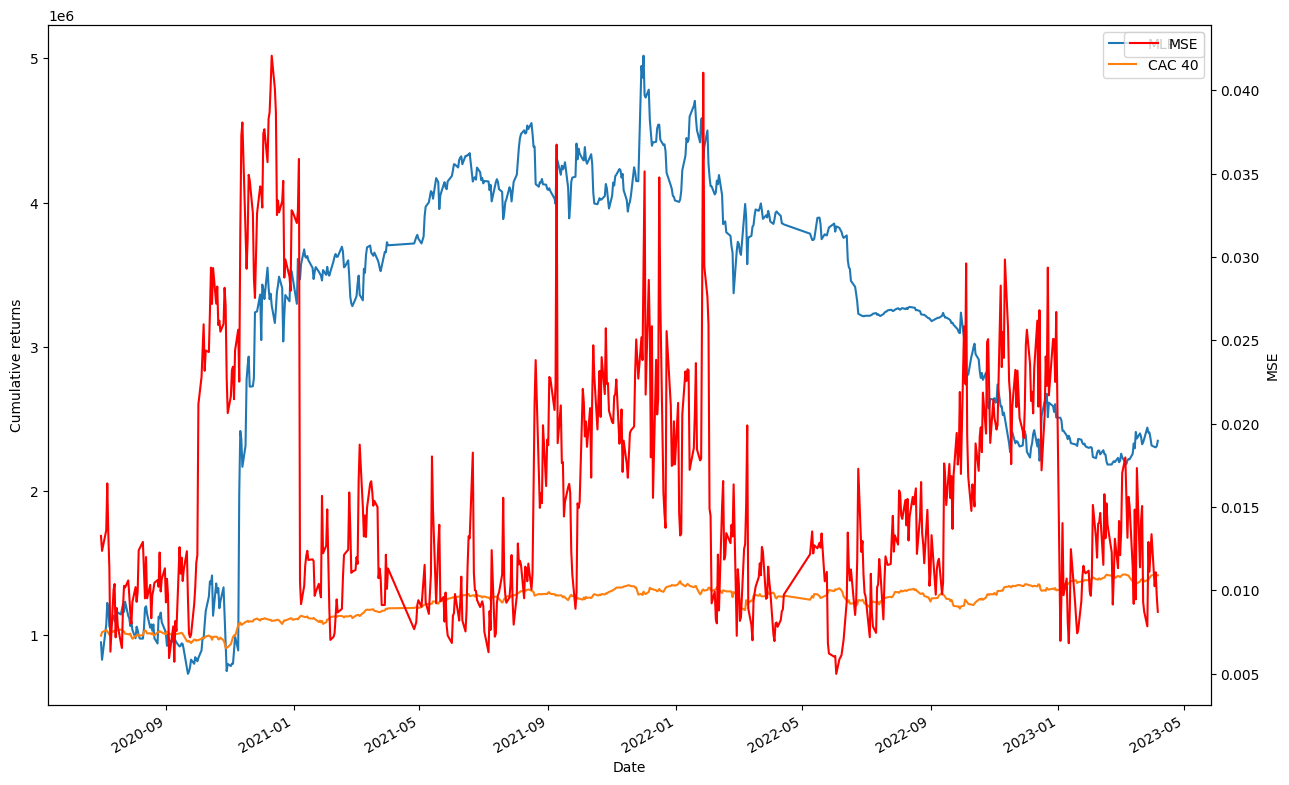

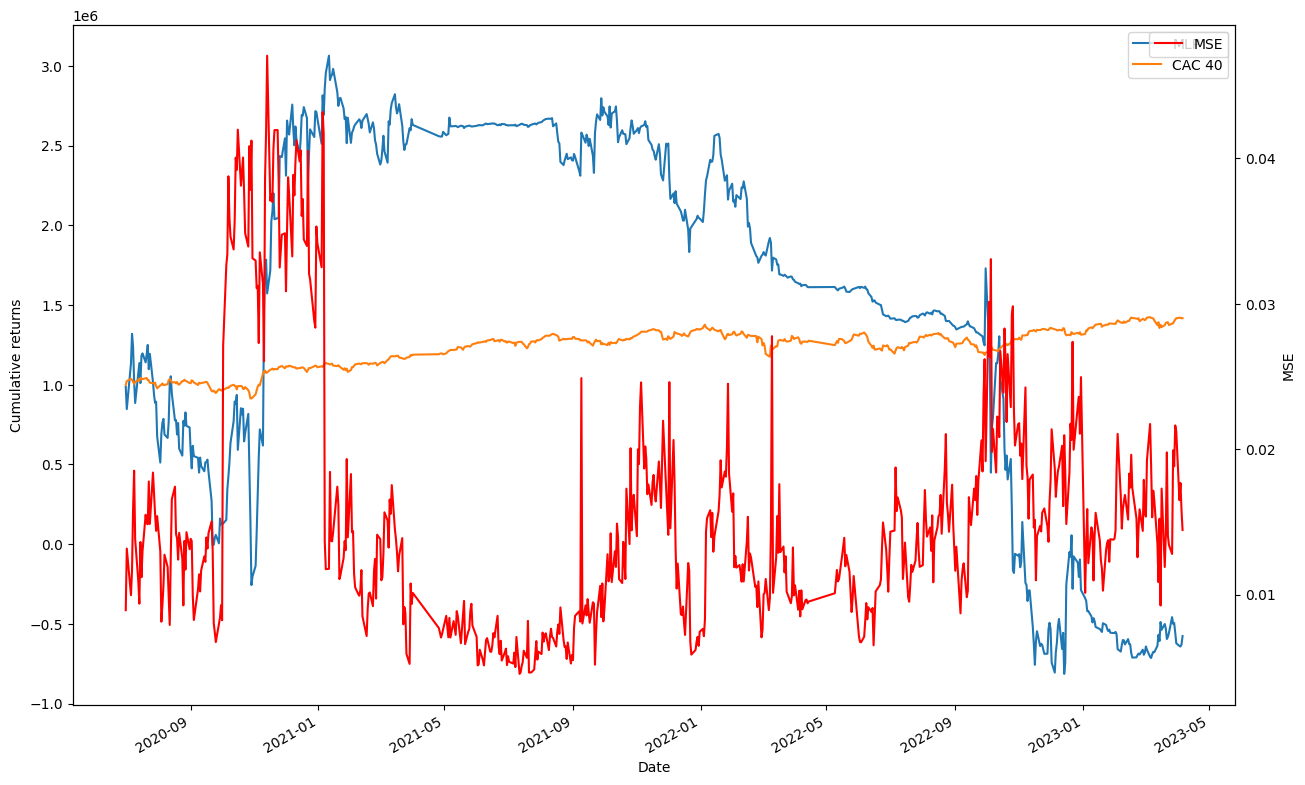

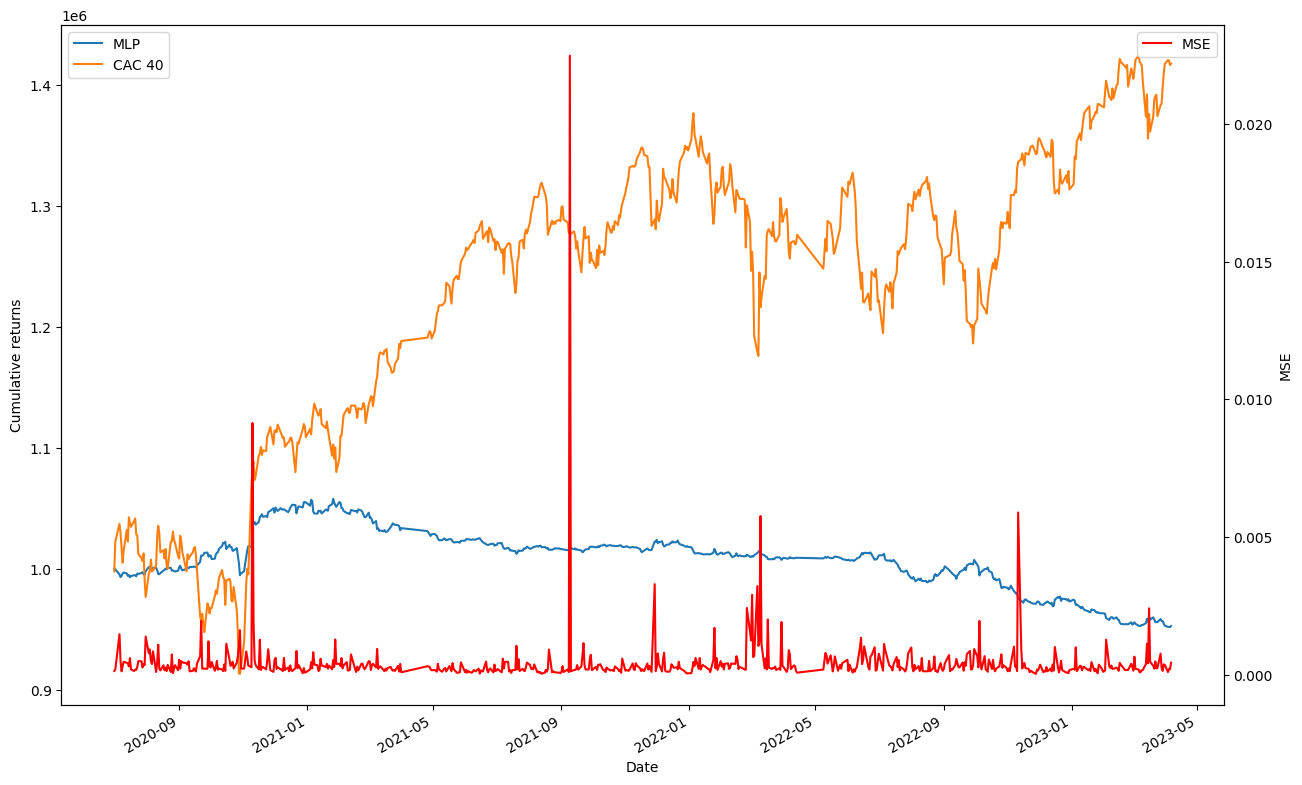

In [286]:
for model in MLP_models: 
    if model.type =="regression":
        w = weights_test[model.name]
        backtest = BackTester(w, returns, capital, risk_free, benchmark=benchmark_returns, name = "MLP")
        backtest_statistics = backtest.get_backtest_statistics()
        print(backtest_statistics)
        cum_returns = backtest.get_strategy_cumulative_returns()
        cum_returns["MSE"] = (forecasts_test[model.name] - returns.loc[test_index_full, :]).apply(lambda x: x**2).mean(axis = 1)

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        cum_returns.plot(y = ["MLP", "CAC 40"], ax = ax1, figsize = (15, 10))
        cum_returns.plot(y = "MSE", ax = ax2, color = "red")
        ax1.set_ylabel("Cumulative returns")
        ax2.set_ylabel("MSE")
        # ax1.set_title("MLP Regression with ")

We repeat this process to generate the classification graphs and statistics: 

Yearly excess returns          -1.501292
Yearly standard deviation       0.150705
Max DD                       2027.353891
Yearly Sharpe                  -9.961816
Yearly Calmar                  -0.000741
Yearly Sortino                -14.889081
Daily Turnover                  0.923108
dtype: float64
Yearly excess returns         -0.753224
Yearly standard deviation      0.185644
Max DD                       225.595591
Yearly Sharpe                 -4.057358
Yearly Calmar                 -0.003339
Yearly Sortino                -6.452146
Daily Turnover                 0.444582
dtype: float64
Yearly excess returns        0.000569
Yearly standard deviation    0.122865
Max DD                       5.015354
Yearly Sharpe                0.004633
Yearly Calmar                0.000113
Yearly Sortino               0.006622
Daily Turnover               0.004019
dtype: float64


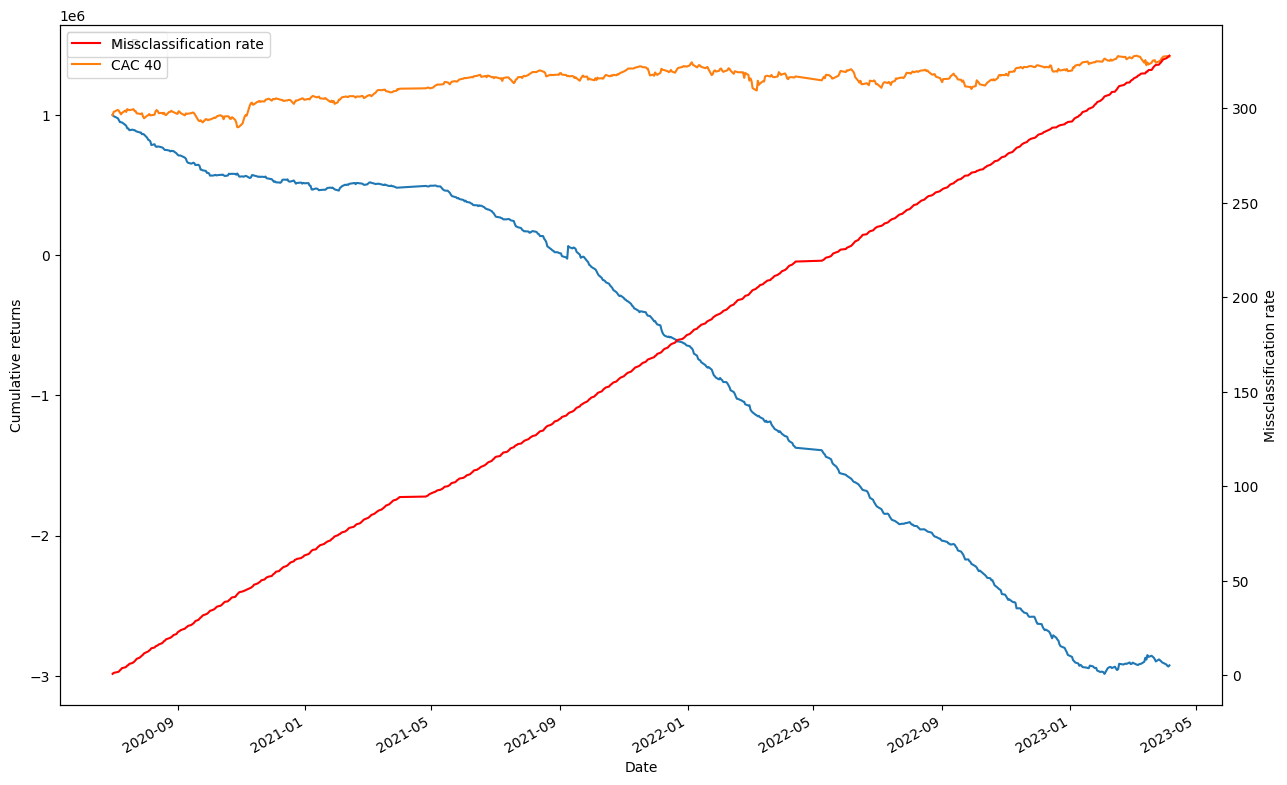

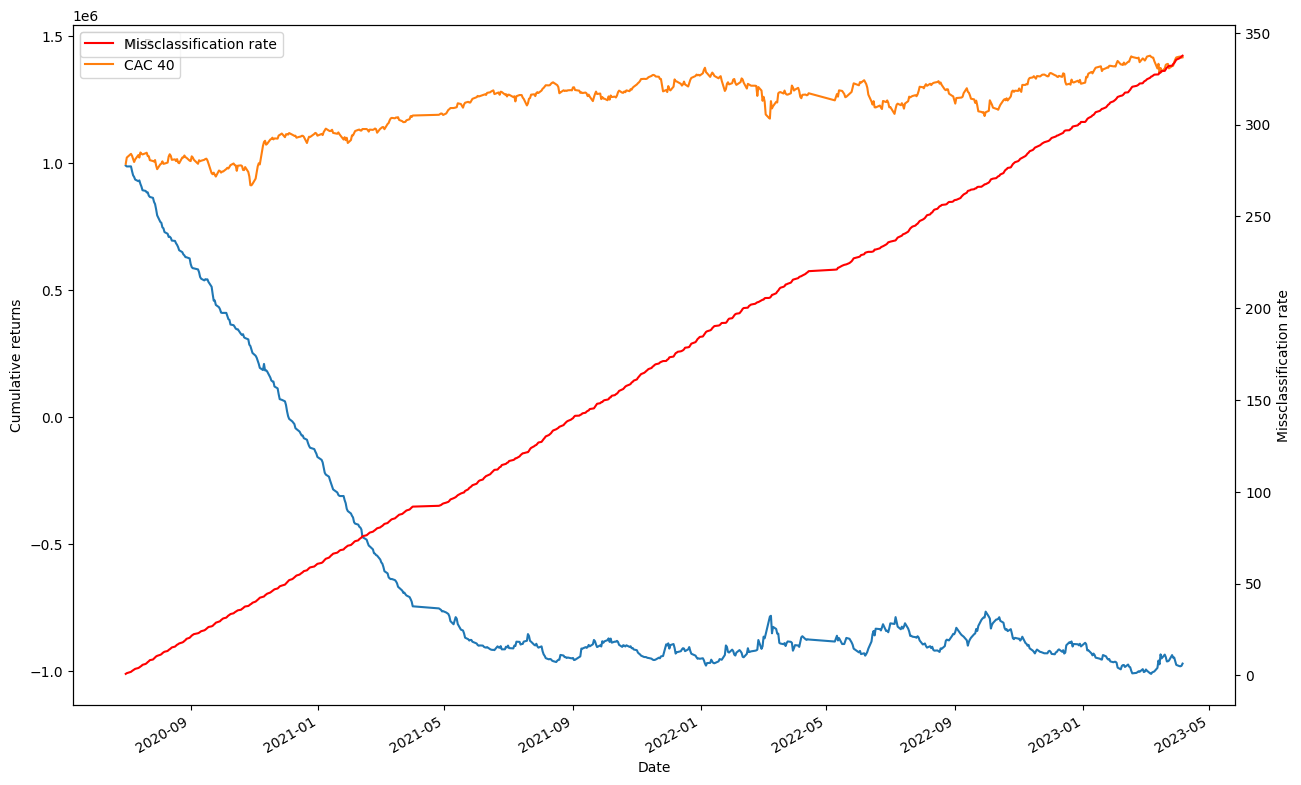

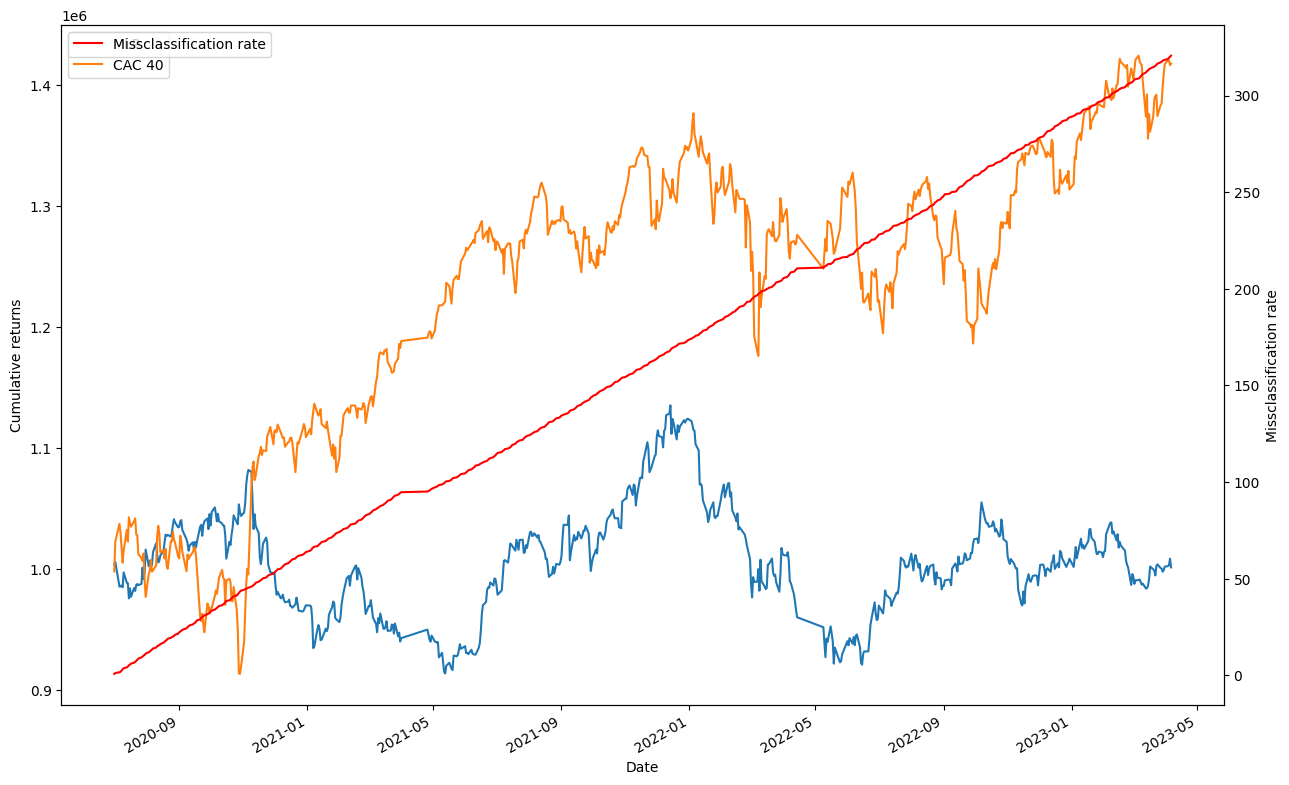

In [287]:
for model in MLP_models: 
    if model.type == "classification":
        w = weights_test[model.name]
        backtest = BackTester(w, returns, capital, risk_free, benchmark=benchmark_returns, name = "MLP")
        backtest_statistics = backtest.get_backtest_statistics()
        print(backtest_statistics)
        cum_returns = backtest.get_strategy_cumulative_returns()
        cum_returns["Missclassification rate"] = ((2*forecasts_test[model.name]-1) != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).cumsum()

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        cum_returns.plot(y = ["MLP", "CAC 40"], ax = ax1, figsize = (15, 10))
        cum_returns.plot(y = "Missclassification rate", ax = ax2, color = "red")
        ax1.set_ylabel("Cumulative returns")
        ax2.set_ylabel("Missclassification rate")

In [88]:
((2*forecasts_test["MultiLayerPerceptronClassification"]-1) != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).mean()

0.49397926634768735

In [288]:
cum_returns["MSE"].sum()

KeyError: 'MSE'

### CNN

In [475]:
from networks import CNN

channels = [64]
print(np.shape(channels))

model_6 = Model(name = "CNNRegression", type = "regression", model_class= CNN(14, channels, 64, model_type="regression"))
model_7 = Model(name = "CNNClassification", type = "classification", model_class= CNN(14, channels, 64, model_type= "classification"))
CNN_models = [model_6] #, model_7]

(1,)


In [476]:
forecasts_val, forecasts_test, weights_valid, weights_test, opt_param_dict, valid_index_full, test_index_full = forecaster.evaluate_test_models(models = CNN_models, prec_mat = prec_mat, lambdas = lambdas, alphas = alphas, thetas = thetas, capital = capital, stock_returns=returns, risk_free=risk_free, benchmark_returns=benchmark_returns)

  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]

(2205, 1)
(66, 1)
(66, 1)
model
torch.Size([64, 14])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x32 and 64x64)

### LSTM

In [481]:
from networks import LSTM
import Forecaster
lstm_models = []
lstm_models.append(Model(name= "LSTMRegression", type = "regression", model_class= LSTM(14, 60, 1, "regression"), is_rnn=True))
lstm_models.append(Model(name= "LSTMClassification", type = "classification", model_class= LSTM(14, 60, 1, "classification"), is_rnn=True))

In [482]:
forecasts_val, forecasts_test, weights_valid, weights_test, opt_param_dict, valid_index_full, test_index_full = forecaster.evaluate_test_models(models = lstm_models, prec_mat = prec_mat, lambdas = lambdas, alphas = alphas, thetas = thetas, capital = capital, stock_returns=returns, risk_free=risk_free, benchmark_returns=benchmark_returns)

0it [00:00, ?it/s]

(2205, 1)
(66, 1)
(66, 1)
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torc

  0%|          | 0/2 [00:14<?, ?it/s]
0it [00:15, ?it/s]

torch.Size([60, 1])
torch.Size([34, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([2, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([2, 60, 14])
torch.Size([60, 1])
torch.Size([64, 60, 14])
torch.Size([60, 1])
torch.Size([2, 60, 14])
torch.Size([60, 1])
(120,)


ValueError: Length of values (120) does not match length of index (66)

### GRU

In [514]:
from networks import GRU
import Forecaster
gru_models = []
gru_models.append(Model(name= "GRURegression", type = "regression", model_class= GRU(14, 64, 1, "regression"), is_rnn=True))
gru_models.append(Model(name= "GRUClassification", type = "classification", model_class= GRU(14, 64, 1, "classification"), is_rnn=True))

In [516]:
forecasts_val_gru, forecasts_test_gru, weights_valid_gru, weights_test_gru, opt_param_dict_gru, valid_index_full_gru, test_index_full_gru = forecaster.evaluate_test_models(models = gru_models, prec_mat = prec_mat, lambdas = lambdas, alphas = alphas, thetas = thetas, capital = capital, stock_returns=returns, risk_free=risk_free, benchmark_returns=benchmark_returns)

100%|██████████| 2/2 [20:33<00:00, 616.85s/it]
10it [3:10:57, 1145.76s/it]

GRURegression
(10, 66, 38)
GRUClassification
(10, 66, 38)


In [520]:
forecasts_val_gru = forecasts_val
forecasts_test_gru = forecasts_test
weights_valid_gru = weights_valid
weights_test_gru = weights_test
opt_param_dict_gru = opt_param_dict
valid_index_full_gru = valid_index_full
test_index_full_gru = test_index_full 

Yearly excess returns       -0.487695
Yearly standard deviation    1.649790
Max DD                       2.219283
Yearly Sharpe               -0.295610
Yearly Calmar               -0.219753
Yearly Sortino              -0.424335
Daily Turnover               0.903226
dtype: float64


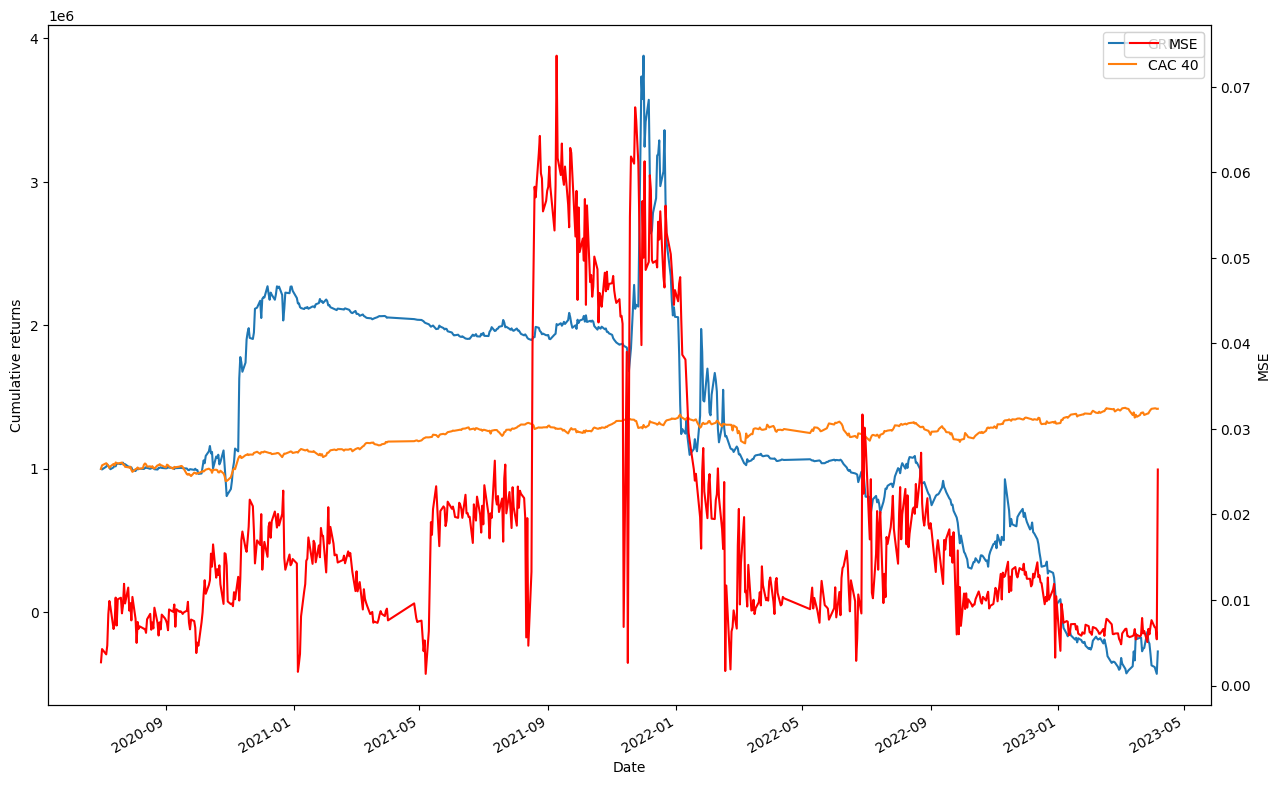

In [521]:
for model in gru_models: 
    if model.type =="regression":
        w = weights_test_gru[model.name]
        backtest = BackTester(w, returns, capital, risk_free, benchmark=benchmark_returns, name = "GRU")
        backtest_statistics = backtest.get_backtest_statistics()
        print(backtest_statistics)
        cum_returns = backtest.get_strategy_cumulative_returns()
        cum_returns["MSE"] = (forecasts_test_gru[model.name] - returns.loc[test_index_full, :]).apply(lambda x: x**2).mean(axis = 1)

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        cum_returns.plot(y = ["GRU", "CAC 40"], ax = ax1, figsize = (15, 10))
        cum_returns.plot(y = "MSE", ax = ax2, color = "red")
        ax1.set_ylabel("Cumulative returns")
        ax2.set_ylabel("MSE")
        # ax1.set_title("MLP Regression with ")

Yearly excess returns         -4.361938
Yearly standard deviation      0.164819
Max DD                       723.223341
Yearly Sharpe                -26.465064
Yearly Calmar                 -0.006031
Yearly Sortino               -30.658844
Daily Turnover                 2.262994
dtype: float64


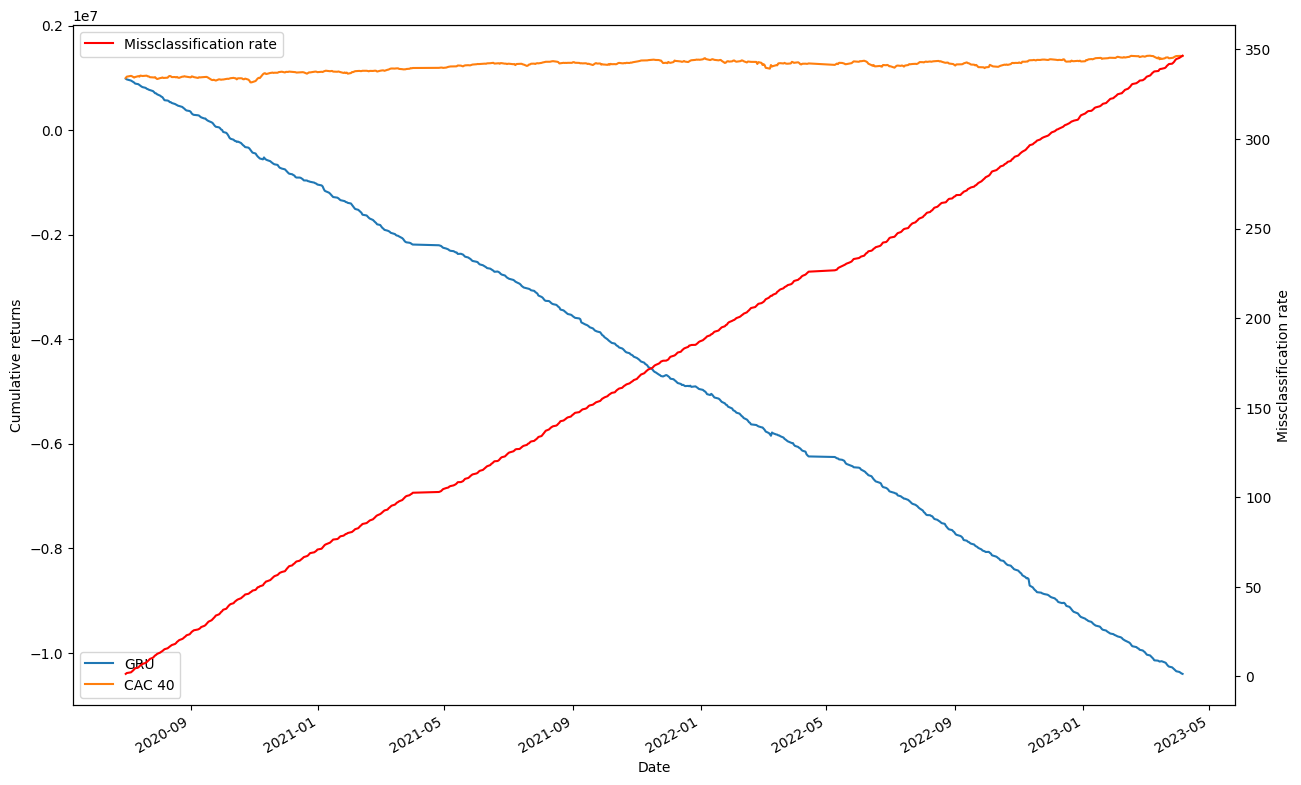

In [522]:
for model in gru_models: 
    if model.type == "classification":
        w = weights_test_gru[model.name]
        backtest = BackTester(w, returns, capital, risk_free, benchmark=benchmark_returns, name = "GRU")
        backtest_statistics = backtest.get_backtest_statistics()
        print(backtest_statistics)
        cum_returns = backtest.get_strategy_cumulative_returns()
        cum_returns["Missclassification rate"] = ((2*forecasts_test_gru[model.name]-1) != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).cumsum()

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        cum_returns.plot(y = ["GRU", "CAC 40"], ax = ax1, figsize = (15, 10))
        cum_returns.plot(y = "Missclassification rate", ax = ax2, color = "red")
        ax1.set_ylabel("Cumulative returns")
        ax2.set_ylabel("Missclassification rate")